<a href="https://colab.research.google.com/github/wweavishay/weather_streamlit/blob/main/weatherapp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
from datetime import datetime, timedelta, timezone
import pytz
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

API_KEY = "cc684ce23b3296f9598c4187825107eb"


In [2]:
# load json setting
def load_settings():
    try:
        with open('settings.json', 'r') as f:
            return json.load(f)
    except (FileNotFoundError, json.JSONDecodeError):
        return {'timezone': 'UTC'}  # Default timezone is UTC

# save json setting
def save_settings(settings):
    with open('settings.json', 'w') as f:
        json.dump(settings, f)


In [4]:
# functions to send data to json file

def set_default_location():
    city_name = input("Enter your default city name: ")
    country_name = input("Enter the country (optional, press Enter to skip): ")
    timezone_name = input("Enter the timezone (e.g., 'Europe/London'): ")

    settings = load_settings()
    default_timezone = settings.get('timezone', 'UTC')

    if timezone_name == default_timezone:
        settings['default_location'] = {'city': city_name, 'country': country_name}
    else:
        settings['default_location'] = {'city': city_name, 'country': country_name, 'timezone': timezone_name}

    save_settings(settings)
    print("Default location set successfully.")


def set_temperature_unit():
    unit = input("Enter your preferred temperature unit (Celsius or Fahrenheit): ").lower()
    if unit in ['celsius', 'fahrenheit']:
        settings = load_settings()
        settings['temperature_unit'] = unit
        save_settings(settings)
        print("Temperature unit preference set successfully.")
    else:
        print("Invalid temperature unit. Please enter either Celsius or Fahrenheit.")


In [5]:
def get_weather(city_name, country_name=None):
    if country_name:
        url = f"http://api.openweathermap.org/data/2.5/weather?q={city_name},{country_name}&appid={API_KEY}&units=metric"
    else:
        url = f"http://api.openweathermap.org/data/2.5/weather?q={city_name}&appid={API_KEY}&units=metric"

    response = requests.get(url)

    if response.status_code != 200:
        print(f"Error: Failed to retrieve weather data.")
        return None

    data = response.json()

    if data["cod"] == "404":
        print("Error: city not found.")
        return None

    return data


In [6]:
def get_user_location():
    settings = load_settings()
    default_location = settings.get('default_location', {})

    city = default_location.get('city')
    country = default_location.get('country')

    if city and country:
        print(f"Default location is set to {city}, {country}.")
        change_location = input("Do you want to change it? (yes/no): ").lower()
        if change_location == 'yes':
            city = input("Enter the new default city name: ")
            country = input("Enter the new default country (optional, press Enter to keep the current country): ")
            print("Default location updated successfully.")
            default_location = {'city': city, 'country': country}  # Update the default location dictionary
    else:
        city = input("Enter your default city name: ")
        country = input("Enter the country (optional, press Enter to skip): ")
        if city:
            print("Default location set successfully.")
            default_location = {'city': city, 'country': country}  # Set the default location dictionary

    return city, country


In [7]:
def find_time_difference(datetime1, datetime2):
    # Extract time zones from datetime objects
    tz1 = datetime1.tzinfo
    tz2 = datetime2.tzinfo

    # Convert both datetime objects to UTC
    datetime1_utc = datetime1.astimezone(pytz.utc)
    datetime2_utc = datetime2.astimezone(pytz.utc)

    # Calculate the difference
    time_diff = datetime1_utc - datetime2_utc

    # Convert the time difference to hours and minutes
    total_seconds = abs(time_diff.total_seconds())
    hours = int(total_seconds // 3600)
    minutes = int((total_seconds % 3600) // 60)

    # Adjust for time zone difference
    if tz1 != tz2:
        hours += abs((datetime1 - datetime1.replace(tzinfo=tz2)).total_seconds() // 3600)

    # Return the difference in hours and minutes
    return hours, minutes


In [8]:
def display_weather_image(temperature):
    # Determine weather image based on temperature conditions
    if float(temperature) < 10:
        image_url = "https://cdn-icons-png.flaticon.com/128/2469/2469994.png"  # Cold icon
    elif 10 <= float(temperature) < 20:
        image_url = "https://cdn-icons-png.flaticon.com/128/1163/1163624.png"  # Moderate icon
    else:
        image_url = "https://cdn-icons-png.flaticon.com/128/9231/9231728.png"  # Warm icon

    # Fetch and display weather image
    response = requests.get(image_url)
    if response.status_code == 200:
        img = Image.open(BytesIO(response.content))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    else:
        print("Error: Could not fetch weather image.")


In [9]:
def display_weather():
    settings = load_settings()
    default_location = settings.get('default_location')

    if not default_location:
        print("Default location not set. Please set default location first.")
        return

    city_name = default_location.get('city')
    country_name = default_location.get('country')
    default_timezone = default_location.get('timezone', 'UTC')  # Use timezone from JSON settings

    weather_data_default = get_weather(city_name, country_name)
    user_city, user_country = get_user_location()
    weather_data_user = get_weather(user_city, user_country)

    if weather_data_default and weather_data_user:
        temperature_default = "{:.2f}".format(weather_data_default["main"]["temp"])
        weather_conditions_default = weather_data_default["weather"][0]["description"]
        humidity_default = weather_data_default["main"]["humidity"]

        temperature_user = "{:.2f}".format(weather_data_user["main"]["temp"])
        weather_conditions_user = weather_data_user["weather"][0]["description"]
        humidity_user = weather_data_user["main"]["humidity"]

        user_settings = load_settings()
        user_timezone = pytz.timezone(user_settings.get('timezone', default_timezone))  # Use timezone from JSON settings or default to default_timezone
        user_time = datetime.now(user_timezone)  # Get current time of user's timezone

        city_timezone_offset_default = weather_data_default["timezone"]
        city_timezone_default = timezone.utc if city_timezone_offset_default == 0 else timezone(timedelta(seconds=city_timezone_offset_default))
        city_time_default = datetime.fromtimestamp(weather_data_default["dt"], city_timezone_default)

        city_timezone_offset_user = weather_data_user["timezone"]
        city_timezone_user = timezone.utc if city_timezone_offset_user == 0 else timezone(timedelta(seconds=city_timezone_offset_user))
        city_time_user = datetime.fromtimestamp(weather_data_user["dt"], city_timezone_user)

        formatted_user_time = user_time.strftime("%d / %m / %Y - %H:%M")
        formatted_city_time_default = city_time_default.strftime("%d / %m / %Y - %H:%M")
        formatted_city_time_user = city_time_user.strftime("%d / %m / %Y - %H:%M")

        print(f"Weather in {city_name}:")
        if user_settings.get('temperature_unit', 'celsius').lower() == 'celsius':
            print(f"Temperature: {temperature_default}°C")
            temperature_f_default = (float(temperature_default))
        else:
            temperature_f_default = (float(temperature_default) * 9 / 5) + 32
            print(f"Temperature: {temperature_f_default}°F")
        print(f"Weather Conditions: {weather_conditions_default}")
        print(f"Humidity: {humidity_default}%")
        print(f"Local Date and Time ({city_name}): {formatted_city_time_default} ({default_timezone})")
        print("")
        display_weather_image(temperature_default)

        print(f"Weather in {user_city.upper()}:")  # Convert user city to uppercase for consistency
        if user_settings.get('temperature_unit', 'celsius').lower() == 'celsius':
            print(f"Temperature: {temperature_user}°C")
            temperature_f_user = (float(temperature_user))
        else:
            temperature_f_user = (float(temperature_user) * 9 / 5) + 32
            print(f"Temperature: {temperature_f_user}°F")
        print(f"Weather Conditions: {weather_conditions_user}")
        print(f"Humidity: {humidity_user}%")
        print(f"Local Date and Time ({user_city.upper()}): {formatted_city_time_user} ({default_timezone})")
        print("")
        display_weather_image(temperature_f_user)

        #print(city_time_default)
        #print(city_time_user)
        hours, minutes = find_time_difference((city_time_user), (city_time_default))
        print("Time difference:", hours, "hours and", minutes, "minutes")


Welcome to the Weather App!
Write the number of the function to choose one: (for example number 3 to display weather )
1. Set Default Location
2. Set Temperature Unit
3. Display Weather
Enter your choice: 1
Enter your default city name: london
Enter the country (optional, press Enter to skip): 
Enter the timezone (e.g., 'Europe/London'): Europe/London
Default location set successfully.
------------------------------------------------------------------------------
Write the number of the function to choose one: (for example number 3 to display weather )
1. Set Default Location
2. Set Temperature Unit
3. Display Weather
Enter your choice: 3
Enter your default city name: tel aviv
Enter the country (optional, press Enter to skip): 
Default location set successfully.
Weather in london:
Temperature: 13.04°C
Weather Conditions: broken clouds
Humidity: 78%
Local Date and Time (london): 01 / 06 / 2024 - 09:10 (Europe/London)



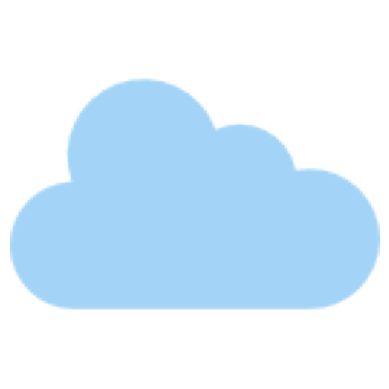

Weather in TEL AVIV:
Temperature: 28.91°C
Weather Conditions: clear sky
Humidity: 33%
Local Date and Time (TEL AVIV): 01 / 06 / 2024 - 11:12 (Europe/London)



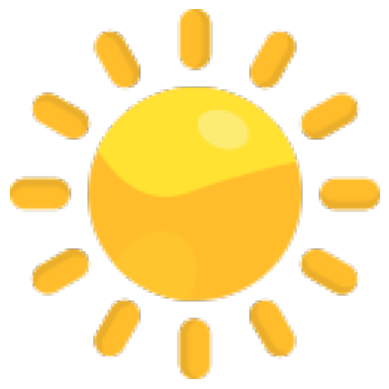

Time difference: 2.0 hours and 1 minutes
------------------------------------------------------------------------------
Write the number of the function to choose one: (for example number 3 to display weather )
1. Set Default Location
2. Set Temperature Unit
3. Display Weather


In [ ]:
def main():
    print("Welcome to the Weather App!")

    while True:
        print("Write the number of the function to choose one: (for example number 3 to display weather )")
        print("1. Set Default Location")
        print("2. Set Temperature Unit")
        print("3. Display Weather")
        choice = input("Enter your choice: ")

        if choice == '1':
            set_default_location()
        elif choice == '2':
            set_temperature_unit()
        elif choice == '3':
            display_weather()
        else:
            print("Invalid choice.")
        print("------------------------------------------------------------------------------")




if __name__ == "__main__":
    main()